## Sprint 1

In [10]:
DATA_FOLDER = "actions"

action_labels = ['jumping jack', 'squat', 'in_place running', 'side lunge', 'boxing', 'overhead press', 'bicep curl']

## Exploratory Data Analysis


### What is contained in the name of each file?

The name of the files all have the following structure: `action-X-group-Y-rec-Z.npy`.
- X defines the type of exercise that was performed
 - 0: Jumping jack
 - 1: Squat
 - 2: In-place running
 - 3: Side lunge
 - 4: Boxing
 - 5: Overhead press
 - 6: Bicep curl
- Y defines the group that performed these exercises
- Z defines the person of that group.

The .npy format is the standard binary file format in NumPy for persisting a single arbitrary NumPy array on disk.

  

### How can you filter data by action, or by group?

In [11]:
import glob

#for actions
filtered_actions = glob.glob(f'{DATA_FOLDER}/*action-[1-2]*.npy')

#for groups
filtered_groups = glob.glob(f'{DATA_FOLDER}/*group-[1-7]*.npy')

Above, it was illustrated how to filter files using standard Regex code.

`*`: this is meant to match any number of characters, including none. This will match any string of characters before the word "action-" or "group-".

`[1-2]`: This part inside square brackets is a character range. It matches a single character that can be either 1 or 2.

A function was made to do this:

In [12]:
def filter_files_by_action_or_group(directory, action_start,action_end, groups_start, groups_end):
    filtered=glob.glob(f"{directory}/*action-[{action_start}-{action_end}]*group-[{groups_start}-{groups_end}]*.npy")
    return filtered

### Is the data balanced?

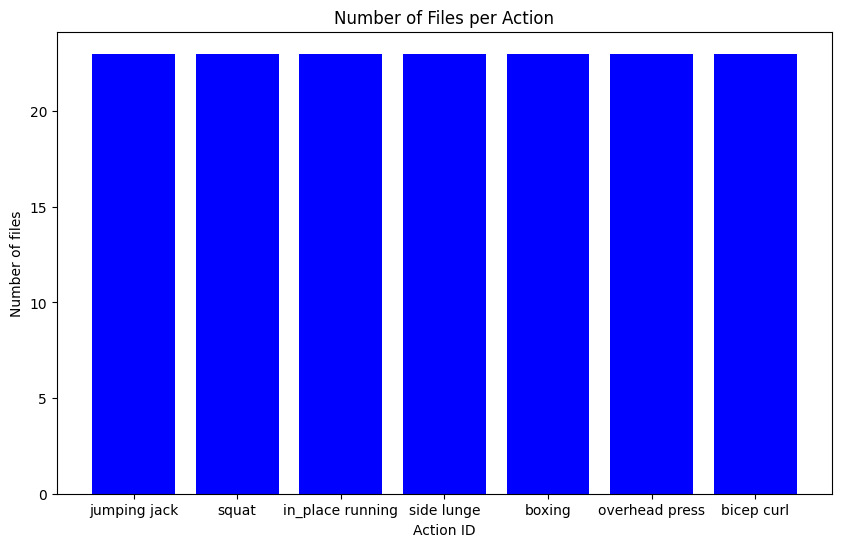

In [13]:
import matplotlib.pyplot as plt

actions = range(0, len(action_labels))
data_count = []

for action in actions:
    files = filter_files_by_action_or_group(DATA_FOLDER, action, action, 0, 9)
    data_count.append(len(files))

plt.figure(figsize=(10, 6))
plt.bar(action_labels, data_count, color='blue')
plt.xlabel('Actions')
plt.ylabel('Number of files')
plt.title('Number of Files per Action')
plt.xticks(actions)
plt.show()

### What does the data look like?

In [16]:
import numpy as np

arr=np.load(filtered_actions[0]) # load 1 file
nb_samples, nb_keypoints, nb_values=arr.shape
arr.shape

(450, 18, 3)

The array consists of 450 samples that contain the 18 keypoints their position. The value contains the X and Y position and the last value is the confidence that this keypoint is in this position.

In [17]:
arr

array([[[339.13041663, 110.03583074,   0.91425604],
        [341.18283582, 166.47735834,   0.86502254],
        [292.95098495, 168.52977753,   0.8816126 ],
        ...,
        [349.39251256, 101.82615399,   0.93395025],
        [318.60622478, 111.06204033,   0.88826299],
        [361.70702767, 110.03583074,   0.89004636]],

       [[339.57155061, 114.30578411,   0.98112571],
        [341.06572831, 169.09230083,   0.87628418],
        [292.7539827 , 171.0845378 ,   0.88074875],
        ...,
        [348.5366168 , 104.34459925,   0.9854877 ],
        [318.65306282, 114.30578411,   0.92334008],
        [361.48615686, 112.31354713,   0.93298388]],

       [[339.88334274, 119.2342428 ,   0.97386569],
        [341.84236018, 174.5764876 ,   0.86433315],
        [292.86692429, 175.06624198,   0.86985403],
        ...,
        [348.6989212 , 109.43915522,   0.97564375],
        [318.33415095, 119.2342428 ,   0.92351258],
        [361.43253454, 117.27522528,   0.91609776]],

       ...,

      

### What are the ranges for each feature?

### Do all (values for all) features make sense? Are there any outliers?